<a href="https://colab.research.google.com/github/w12l3-c/Waterloo_BME/blob/main/Heart_Disease_Classify.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Heart Disease
### Download from Kaggle

In [1]:
! pip install kaggle

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [2]:
from google.colab import files
files.upload()

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"wallacel","key":"d4846c13171812a348c366972bd73a6b"}'}

In [4]:
! cp kaggle.json ~/.kaggle/
! chmod 600 ~/.kaggle/kaggle.json
! kaggle datasets download -d kamilpytlak/personal-key-indicators-of-heart-disease

  0% 0.00/3.13M [00:00<?, ?B/s]
100% 3.13M/3.13M [00:00<00:00, 163MB/s]


In [5]:
! mkdir dataset
! unzip personal-key-indicators-of-heart-disease.zip -d dataset

Archive:  personal-key-indicators-of-heart-disease.zip
  inflating: dataset/heart_2020_cleaned.csv  


### Libraries and Dataset Download

In [2]:
import tensorflow as tf
from tensorflow import keras
from keras import layers
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import sklearn as sk
import seaborn as sb

In [7]:
heart = pd.read_csv("/content/dataset/heart_2020_cleaned.csv", index_col=False)

In [8]:
heart.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 319795 entries, 0 to 319794
Data columns (total 18 columns):
 #   Column            Non-Null Count   Dtype  
---  ------            --------------   -----  
 0   HeartDisease      319795 non-null  object 
 1   BMI               319795 non-null  float64
 2   Smoking           319795 non-null  object 
 3   AlcoholDrinking   319795 non-null  object 
 4   Stroke            319795 non-null  object 
 5   PhysicalHealth    319795 non-null  float64
 6   MentalHealth      319795 non-null  float64
 7   DiffWalking       319795 non-null  object 
 8   Sex               319795 non-null  object 
 9   AgeCategory       319795 non-null  object 
 10  Race              319795 non-null  object 
 11  Diabetic          319795 non-null  object 
 12  PhysicalActivity  319795 non-null  object 
 13  GenHealth         319795 non-null  object 
 14  SleepTime         319795 non-null  float64
 15  Asthma            319795 non-null  object 
 16  KidneyDisease     31

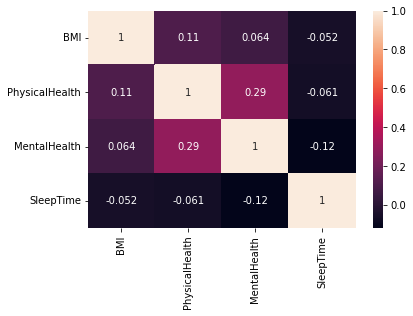

In [13]:
# Heatmap
dataplot = sb.heatmap(heart.corr(), annot=True)

In [15]:
heart.head()

,HeartDisease,BMI,Smoking,AlcoholDrinking,Stroke,PhysicalHealth,MentalHealth,DiffWalking,Sex,AgeCategory,Race,Diabetic,PhysicalActivity,GenHealth,SleepTime,Asthma,KidneyDisease,SkinCancer
0,No,16.60,Yes,No,No,3.0,30.0,No,Female,55-59,White,Yes,Yes,Very good,5.0,Yes,No,Yes
1,No,20.34,No,No,Yes,0.0,0.0,No,Female,80 or older,White,No,Yes,Very good,7.0,No,No,No
2,No,26.58,Yes,No,No,20.0,30.0,No,Male,65-69,White,Yes,Yes,Fair,8.0,Yes,No,No
3,No,24.21,No,No,No,0.0,0.0,No,Female,75-79,White,No,No,Good,6.0,No,No,Yes
4,No,23.71,No,No,No,28.0,0.0,Yes,Female,40-44,White,No,Yes,Very good,8.0,No,No,No


### Prepare dataset

In [10]:
from sklearn.preprocessing import OneHotEncoder

# creating instance of one-hot-encoder
encoder = OneHotEncoder(handle_unknown='ignore')
binary = ['Smoking', 'AlcoholDrinking', 'Stroke', 'DiffWalking', 'Sex', 'Race', 'Diabetic', 'PhysicalActivity', 'GenHealth', 'Asthma', 'KidneyDisease', 'SkinCancer']
rename = []

# perform one-hot encoding on 'team' column 
encoder_df = pd.DataFrame(encoder.fit_transform(heart[binary]).toarray())
# naming the encode (N, Y, N, N, N, Y, Y, Y, N, Y)
for name in binary:
  yes = name + '_Y'
  no = name + '_N'
  rename.append(no)
  rename.append(yes)
#encoder_df.columns = rename

# merge one-hot encoded columns back with original DataFrame
final_df = heart.join(encoder_df)

In [11]:
# This is the exact same thing but using pandas library
heart_encoded = pd.get_dummies(heart, columns=binary)

In [76]:
heart_encoded.head(3)

,HeartDisease,BMI,PhysicalHealth,MentalHealth,AgeCategory,SleepTime,Smoking_No,Smoking_Yes,AlcoholDrinking_No,AlcoholDrinking_Yes,Stroke_No,Stroke_Yes,DiffWalking_No,DiffWalking_Yes,Sex_Female,Sex_Male,Race_American Indian/Alaskan Native,Race_Asian,Race_Black,Race_Hispanic,Race_Other,Race_White,Diabetic_No,"Diabetic_No, borderline diabetes",Diabetic_Yes,Diabetic_Yes (during pregnancy),PhysicalActivity_No,PhysicalActivity_Yes,GenHealth_Excellent,GenHealth_Fair,GenHealth_Good,GenHealth_Poor,GenHealth_Very good,Asthma_No,Asthma_Yes,KidneyDisease_No,KidneyDisease_Yes,SkinCancer_No,SkinCancer_Yes
0,No,16.60,3.0,30.0,55-59,5.0,0,1,1,0,1,0,1,0,1,0,0,0,0,0,0,1,0,0,1,0,0,1,0,0,0,0,1,0,1,1,0,0,1
1,No,20.34,0.0,0.0,80 or older,7.0,1,0,1,0,0,1,1,0,1,0,0,0,0,0,0,1,1,0,0,0,0,1,0,0,0,0,1,1,0,1,0,1,0
2,No,26.58,20.0,30.0,65-69,8.0,0,1,1,0,1,0,1,0,0,1,0,0,0,0,0,1,0,0,1,0,0,1,0,1,0,0,0,0,1,1,0,1,0


In [12]:
# Deal with the Age Category
age = heart.loc[:, 'AgeCategory']

def age_value(word):
  word = int(word[:2])
  if word == 80:
    return 85
  else:
    return (word+4)/2

In [13]:
age = age.apply(age_value, args=())

In [14]:
heart_encoded = heart_encoded.drop(labels="AgeCategory", axis=1)
heart_encoded = heart_encoded.join(age)

In [80]:
heart_encoded.head(3)

,HeartDisease,BMI,PhysicalHealth,MentalHealth,SleepTime,Smoking_No,Smoking_Yes,AlcoholDrinking_No,AlcoholDrinking_Yes,Stroke_No,Stroke_Yes,DiffWalking_No,DiffWalking_Yes,Sex_Female,Sex_Male,Race_American Indian/Alaskan Native,Race_Asian,Race_Black,Race_Hispanic,Race_Other,Race_White,Diabetic_No,"Diabetic_No, borderline diabetes",Diabetic_Yes,Diabetic_Yes (during pregnancy),PhysicalActivity_No,PhysicalActivity_Yes,GenHealth_Excellent,GenHealth_Fair,GenHealth_Good,GenHealth_Poor,GenHealth_Very good,Asthma_No,Asthma_Yes,KidneyDisease_No,KidneyDisease_Yes,SkinCancer_No,SkinCancer_Yes,AgeCategory
0,No,16.60,3.0,30.0,5.0,0,1,1,0,1,0,1,0,1,0,0,0,0,0,0,1,0,0,1,0,0,1,0,0,0,0,1,0,1,1,0,0,1,29.5
1,No,20.34,0.0,0.0,7.0,1,0,1,0,0,1,1,0,1,0,0,0,0,0,0,1,1,0,0,0,0,1,0,0,0,0,1,1,0,1,0,1,0,85.0
2,No,26.58,20.0,30.0,8.0,0,1,1,0,1,0,1,0,0,1,0,0,0,0,0,1,0,0,1,0,0,1,0,1,0,0,0,0,1,1,0,1,0,34.5


In [15]:
# Deal with the Heart_Disease that is to predict
# No heart disease to 0 and Yes heart disease to 1
heart_disease = heart.loc[:, 'HeartDisease']

def heart_history(word):
  if word == 'Yes':
    return 1.0
  else:
    return 0.0

In [16]:
heart_disease = heart_disease.apply(heart_history, args=())

In [17]:
heart_encoded = heart_encoded.drop(labels="HeartDisease", axis=1)
heart_encoded = heart_encoded.join(heart_disease)

In [84]:
heart_encoded.head(3)

,BMI,PhysicalHealth,MentalHealth,SleepTime,Smoking_No,Smoking_Yes,AlcoholDrinking_No,AlcoholDrinking_Yes,Stroke_No,Stroke_Yes,DiffWalking_No,DiffWalking_Yes,Sex_Female,Sex_Male,Race_American Indian/Alaskan Native,Race_Asian,Race_Black,Race_Hispanic,Race_Other,Race_White,Diabetic_No,"Diabetic_No, borderline diabetes",Diabetic_Yes,Diabetic_Yes (during pregnancy),PhysicalActivity_No,PhysicalActivity_Yes,GenHealth_Excellent,GenHealth_Fair,GenHealth_Good,GenHealth_Poor,GenHealth_Very good,Asthma_No,Asthma_Yes,KidneyDisease_No,KidneyDisease_Yes,SkinCancer_No,SkinCancer_Yes,AgeCategory,HeartDisease
0,16.60,3.0,30.0,5.0,0,1,1,0,1,0,1,0,1,0,0,0,0,0,0,1,0,0,1,0,0,1,0,0,0,0,1,0,1,1,0,0,1,29.5,0.0
1,20.34,0.0,0.0,7.0,1,0,1,0,0,1,1,0,1,0,0,0,0,0,0,1,1,0,0,0,0,1,0,0,0,0,1,1,0,1,0,1,0,85.0,0.0
2,26.58,20.0,30.0,8.0,0,1,1,0,1,0,1,0,0,1,0,0,0,0,0,1,0,0,1,0,0,1,0,1,0,0,0,0,1,1,0,1,0,34.5,0.0


In [18]:
heart_encoded.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 319795 entries, 0 to 319794
Data columns (total 39 columns):
 #   Column                               Non-Null Count   Dtype  
---  ------                               --------------   -----  
 0   BMI                                  319795 non-null  float64
 1   PhysicalHealth                       319795 non-null  float64
 2   MentalHealth                         319795 non-null  float64
 3   SleepTime                            319795 non-null  float64
 4   Smoking_No                           319795 non-null  uint8  
 5   Smoking_Yes                          319795 non-null  uint8  
 6   AlcoholDrinking_No                   319795 non-null  uint8  
 7   AlcoholDrinking_Yes                  319795 non-null  uint8  
 8   Stroke_No                            319795 non-null  uint8  
 9   Stroke_Yes                           319795 non-null  uint8  
 10  DiffWalking_No                       319795 non-null  uint8  
 11  DiffWalking_Y

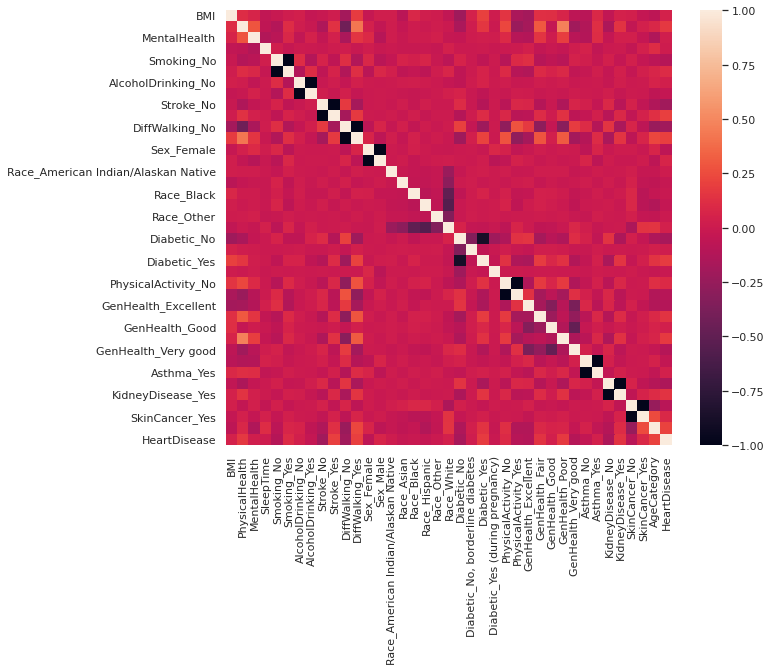

In [19]:
sb.set(rc={'figure.figsize':(10,8)})
sb.heatmap(heart_encoded.corr()) #, annot=True

### Separating into Test Train
---
There are 319795 entire and I am spliting 80-10-10 for train-val-test

In [243]:
train=heart_encoded.sample(frac=0.9, ignore_index=True)
test=heart_encoded.drop(train.index)

In [ ]:
train.head(2)

In [ ]:
test.head(2)

In [244]:
# Split train, test, val into labels and results
train_x, train_y = train.loc[:, train.columns != 'HeartDisease'], train.loc[:,train.columns == "HeartDisease"]
test_x, test_y = test.loc[:, test.columns != 'HeartDisease'], test.loc[:,test.columns == "HeartDisease"]
# val_x, val_y = val.loc[:, val.columns != 'HeartDisease'], val.loc[:,val.columns == "HeartDisease"]

In [245]:
train_x.head(2)

,BMI,PhysicalHealth,MentalHealth,SleepTime,Smoking_No,Smoking_Yes,AlcoholDrinking_No,AlcoholDrinking_Yes,Stroke_No,Stroke_Yes,...,GenHealth_Good,GenHealth_Poor,GenHealth_Very good,Asthma_No,Asthma_Yes,KidneyDisease_No,KidneyDisease_Yes,SkinCancer_No,SkinCancer_Yes,AgeCategory
0,23.09,0.0,0.0,8.0,1,0,1,0,1,0,...,0,0,1,1,0,1,0,1,0,29.5
1,25.84,0.0,15.0,7.0,0,1,1,0,1,0,...,0,0,1,1,0,1,0,1,0,22.0


In [ ]:
train_y.head(2)

In [248]:
test_x.head(2)

,BMI,PhysicalHealth,MentalHealth,SleepTime,Smoking_No,Smoking_Yes,AlcoholDrinking_No,AlcoholDrinking_Yes,Stroke_No,Stroke_Yes,...,GenHealth_Good,GenHealth_Poor,GenHealth_Very good,Asthma_No,Asthma_Yes,KidneyDisease_No,KidneyDisease_Yes,SkinCancer_No,SkinCancer_Yes,AgeCategory
287816,31.25,30.0,30.0,5.0,0,1,1,0,1,0,...,0,0,0,1,0,1,0,1,0,22.0
287817,30.23,0.0,0.0,10.0,0,1,1,0,1,0,...,0,0,0,1,0,1,0,1,0,32.0


In [ ]:
test_y.head(2)

In [ ]:
print("Dataframe size")
print(f"train_x size: {train_x.shape}")
print(f"train_y size: {train_y.shape}")
print(f"test_x size: {test_x.shape}")
print(f"test_y size: {test_y.shape}")

In [139]:
batch_size = 128
train_x = tf.data.Dataset.from_tensor_slices(train_x) # train_x.to_dict('list') will make it a dictionary
train_x = train_x.batch(batch_size)
train_y = tf.data.Dataset.from_tensor_slices(train_y)
train_y = train_y.batch(batch_size)
test_x = tf.data.Dataset.from_tensor_slices(test_x)
test_x = test_x.batch(batch_size)
test_y = tf.data.Dataset.from_tensor_slices(test_y)
test_y = test_y.batch(batch_size)

In [137]:
train_x = tf.keras.utils.normalize(np.array(train_x)) # train_x.to_dict('list') will make it a dictionary
# train_y = tf.convert_to_tensor(tf.keras.utils.normalize(np.array(train_y)))
test_x = tf.keras.utils.normalize(np.array(test_x))
# test_y = tf.convert_to_tensor(tf.keras.utils.normalize(np.array(test_y)))

In [140]:
batch_trainx = train_x.take(1)
batch_trainy = train_y.take(1)
batch_testx = test_x.take(1)
batch_testy = test_y.take(1)

print(f"After convert to tensor")
print(f"train_x size: {batch_trainx.element_spec.shape}")
print(f"train_y size: {batch_trainy.element_spec.shape}")
print(f"test_x size: {batch_testx.element_spec.shape}")
print(f"test_y size: {batch_testy.element_spec.shape}")

After convert to tensor
train_x size: (None, 38)
train_y size: (None, 1)
test_x size: (None, 38)
test_y size: (None, 1)


### Model
---
I am doing it in Functional API for Learning
But Sequential is still there

In [23]:
# Callback when accuracy reach 92
class CallBack(tf.keras.callbacks.Callback):
  def on_epoch_end(self, epoch, logs={}):
    if (logs.get("accuracy") is not None):
      if (logs.get("accuracy") == 0.90):
        print("Model stop training")
        self.model.stop_training = True

In [131]:
# delete the model if I done something wrong
model = None

In [24]:
# Model
# Input layer
input_layer = layers.Input(shape=(38,))

# Hidden layer
hidden_layer1 = layers.Dense(units=256, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(l=0.01))(input_layer)
dropout_layer1 = layers.Dropout(0.5)(hidden_layer1)
bnorm_layer1 = layers.BatchNormalizationV2()(dropout_layer1)
hidden_layer2 = layers.Dense(units=256, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(l=0.01))(bnorm_layer1)
dropout_layer2 = layers.Dropout(0.5)(hidden_layer2)
bnorm_layer2 = layers.BatchNormalizationV2()(dropout_layer2)
hidden_layer3 = layers.Dense(units=64, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(l=0.01))(bnorm_layer2)
dropout_layer3 = layers.Dropout(0.5)(hidden_layer3)
bnorm_layer3 = layers.BatchNormalizationV2()(dropout_layer3)
hidden_layer4 = layers.Dense(units=16, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(l=0.01))(bnorm_layer3)

# Output layer
output_layer = layers.Dense(units=1, activation='sigmoid')(hidden_layer4)

# Create the model
model = tf.keras.Model(inputs=input_layer, outputs=output_layer, name="Heart_Disease_Classification")

In [246]:
model.summary()

Model: "Heart_Disease_Classification"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 38)]              0         
                                                                 
 dense (Dense)               (None, 256)               9984      
                                                                 
 dropout (Dropout)           (None, 256)               0         
                                                                 
 batch_normalization (BatchN  (None, 256)              1024      
 ormalization)                                                   
                                                                 
 dense_1 (Dense)             (None, 256)               65792     
                                                                 
 dropout_1 (Dropout)         (None, 256)               0         
                                      

In [247]:
# compile the model
model.compile(optimizer='adam', loss=keras.losses.MAE, metrics=['accuracy'])

In [249]:
# train model
model.fit(train_x, train_y, epochs=3, verbose=1, callbacks=[CallBack()])

Epoch 1/3
8995/8995 [==============================] - 46s 5ms/step - loss: 0.0856 - accuracy: 0.9145
Epoch 2/3
8995/8995 [==============================] - 44s 5ms/step - loss: 0.0855 - accuracy: 0.9145
Epoch 3/3
8995/8995 [==============================] - 44s 5ms/step - loss: 0.0855 - accuracy: 0.9145


In [250]:
# evaluate the model
test_loss, test_acc = model.evaluate(test_x, test_y, verbose=1)
print("The test accuracy is:", test_acc)
print("The test loss is:", test_loss)

1000/1000 [==============================] - 2s 2ms/step - loss: 0.0863 - accuracy: 0.9137
The test accuracy is: 0.9136620759963989
The test loss is: 0.08633790910243988


In [144]:
# Sequential API
normalization = layers.Normalization()
normalization.adapt(np.array(train_x))

modelS = keras.Sequential([
  normalization,
  layers.Dense(256, activation="relu", kernel_regularizer=tf.keras.regularizers.l2(l=0.01)),
  layers.Dropout(0.5),
  layers.BatchNormalizationV2(),
  layers.Dense(256, activation="relu", kernel_regularizer=tf.keras.regularizers.l2(l=0.01)),
  layers.Dropout(0.5),
  layers.BatchNormalizationV2(),
  layers.Dense(64, activation="relu", kernel_regularizer=tf.keras.regularizers.l2(l=0.01)),
  layers.Dropout(0.5),
  layers.BatchNormalizationV2(),
  layers.Dense(64, activation="relu", kernel_regularizer=tf.keras.regularizers.l2(l=0.01)),
  layers.Dropout(0.5),
  layers.BatchNormalizationV2(),
  layers.Dense(16, activation="relu", kernel_regularizer=tf.keras.regularizers.l2(l=0.01)),
  layers.Dense(1, activation="sigmoid")
])

In [145]:
modelS.compile(optimizer='adam', loss='MeanSquaredError', metrics=['accuracy'])

In [130]:
modelS.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 normalization_1 (Normalizat  (None, 38)               77        
 ion)                                                            
                                                                 
 dense_11 (Dense)            (None, 256)               9984      
                                                                 
 dropout_7 (Dropout)         (None, 256)               0         
                                                                 
 batch_normalization_8 (Batc  (None, 256)              1024      
 hNormalization)                                                 
                                                                 
 dense_12 (Dense)            (None, 256)               65792     
                                                                 
 dropout_8 (Dropout)         (None, 256)              

In [146]:
history = modelS.fit(train_x, train_y, epochs=3, verbose=1, batch_size=256)

Epoch 1/3
1125/1125 [==============================] - 15s 12ms/step - loss: 0.3344 - accuracy: 0.8994
Epoch 2/3
1125/1125 [==============================] - 14s 12ms/step - loss: 0.0789 - accuracy: 0.9143
Epoch 3/3
1125/1125 [==============================] - 13s 12ms/step - loss: 0.0778 - accuracy: 0.9143


In [118]:
# evaluate the model
test_loss, test_acc = modelS.evaluate(test_x, test_y, verbose=1)
print("The test accuracy is:", test_acc)
print("The test loss is:", test_loss)

1000/1000 [==============================] - 2s 2ms/step - loss: 0.0761 - accuracy: 0.9137
The test accuracy is: 0.9136620759963989
The test loss is: 0.07608336955308914


In [119]:
# predict the test case
prediction = model.predict(test_x)

1000/1000 [==============================] - 2s 2ms/step


dict_keys(['loss', 'accuracy'])


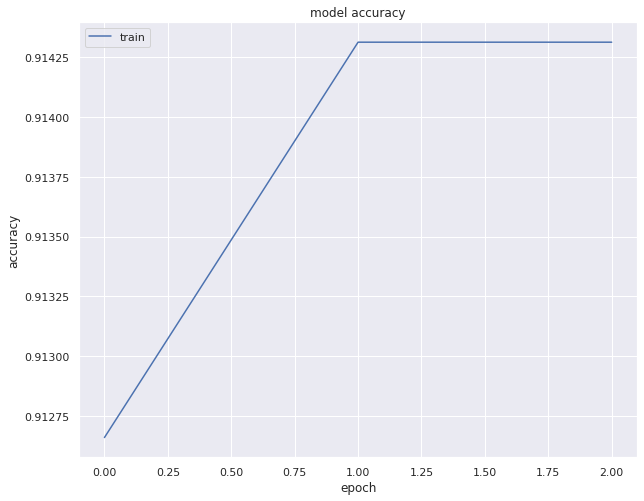

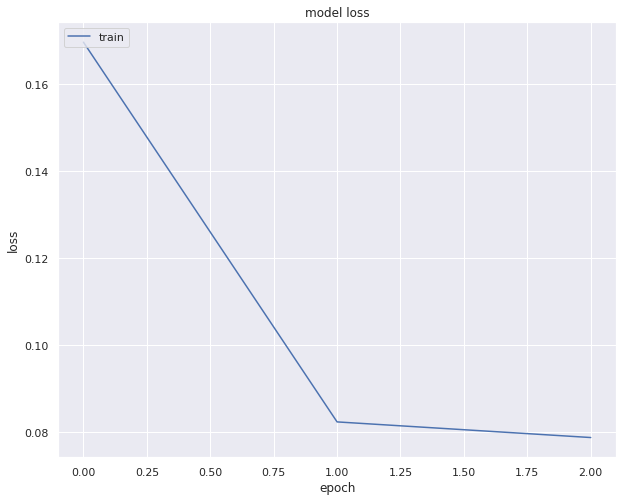

In [122]:
# list all data in history
print(history.history.keys())
# summarize history for accuracy
plt.plot(history.history['accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()
# summarize history for loss
plt.plot(history.history['loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [123]:
print(prediction)

[[0.6783671 ]
 [0.55683494]
 [0.4950283 ]
 ...
 [0.5408609 ]
 [0.5314044 ]
 [0.501616  ]]


In [241]:
def convert_back(value):
  return np.where(value >= 0.5000000, 1.0, 0.0)

In [182]:
result = pd.DataFrame(prediction)
result.columns = ['HeartDieasePred']

In [237]:
#test_y = test_y.reset_index()
#test_y = test_y.drop(labels='level_0', axis=1)
result_apply = result.apply(convert_back)
result_apply.columns = ["Rounded"]
result_test_cmp = result_apply.join(test_y)
result_test_cmp = result_test_cmp.join(result)

In [238]:
result_test_cmp.iloc[100:110]

,Rounded,HeartDisease,HeartDieasePred
100,1.0,0.0,0.443628
101,0.0,0.0,0.526068
102,0.0,0.0,0.522317
103,0.0,0.0,0.530303
104,0.0,0.0,0.533738
105,1.0,0.0,0.435952
106,0.0,0.0,0.526209
107,1.0,0.0,0.482560
108,0.0,0.0,0.508840
109,1.0,0.0,0.452600


In [ ]:
# Saving the Model
model.save("heart_disease_classification.h5")
new_model = tf.keras.models.load_models('heart_disease_classification.h5')

In [91]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

In [239]:
# Confusion Matrix
cm = confusion_matrix(test_y, result_apply)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)

In [ ]:
disp.plot()
plt.grid(False)
plt.show()

In [9]:
# Dummy Case
sample = {
    'BMI': [23.73],
    'Smoking': ['No'],
    'AlcoholDrinking': ['No'],
    'Stroke': ['No'],
    'PhysicalHealth': [0.0],
    'MentalHealth': [0.0],
    'DiffWalking': 'No',
    'Sex': ['Male'],
    'AgeCategory': ["75-59"],
    'Race': ['White'],
    'Diabetic': ['No'],
    'PhysicalActivity': ['Yes'],
    'GenHealth': ["Good"],
    'SleepTime': [6.0],
    'Asthma': ['No'],
    'KidneyDisease': ['No'],
    'SkinCancer': ['Yes']
}
df = pd.DataFrame(sample)
binary = ['Smoking', 'AlcoholDrinking', 'Stroke', 'DiffWalking', 'Sex', 'Race', 'Diabetic', 'PhysicalActivity', 'GenHealth', 'Asthma', 'KidneyDisease', 'SkinCancer']
sample_encoded = pd.get_dummies(df, columns=binary)
age = sample_encoded.loc[:, 'AgeCategory']

def age_value(word):
  word = int(word[:2])
  if word == 80:
    return 85
  else:
    return (word+4)/2

age = age.apply(age_value, args=())

sample_encoded = sample_encoded.drop(labels="AgeCategory", axis=1)
sample_encoded = sample_encoded.join(age)
sample_encoded = np.array(sample_encoded)

predictions = model.predict(sample_encoded)
prob = tf.nn.sigmoid(predictions[0])
print(prob)